In this article I aim at go through the process of analysis of a sample database, a database that I built while tracking a few of my habits with the [HabitBull](http://www.habitbull.com) app. With the app I daily import manually the data. The insights on the data provided by app are useful at the original purpose of the app, i.e. habit formation. However, they may be considered insufficient for my purpose of keeping track of the evolution of my habit through different phases of my life. **And what better reason for some exploratory data analysis than this?!** 

In [1]:
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import datetime

In [2]:
cwd = os.getcwd()
df = pd.read_csv(os.path.join(cwd, 'HabitBulldata.csv'))

## Exploration Data Analysis of our dataframe
We print all of the columns in the dataframe provided by the app:

In [3]:
print(df.columns)

Index(['HabitName', 'HabitDescription', 'HabitCategory', 'CalendarDate',
       'Value', 'CommentText'],
      dtype='object')


From this we can determine the columns that we are interested in:
- ✅ **HabitName**: name of the habit recorded. In the app we can track many different habits but the exported data lists all of the entries in a single long table. This is fundamental to differentiate the values in the various different habits;
- **HabitDescription**: description given to the habit. Not useful for its analysis, could contain, however, information on the meaning of the value recorded;
- **HabitCategory**: not relevant for our analysis. Different habits could, however, be given a different category so some kind of analysis could be made on this basis;
- ✅ **CalendarDate**: date of the entry. Useful for plotting the data;
- ✅ **Value**: entry of the habit. Key information of our database;
- **CommentText**: single entries could be given a comment. Not used in our case.

In conclusion we are only interested in the columns tagged with the checkmark ✅. We can remove the useless information from our dataFrame:

In [4]:
df = df.loc[:,['HabitName', 'CalendarDate', 'Value']]

Now we can start actually visualizing the content of our database:

In [5]:
df.head()

,HabitName,CalendarDate,Value
0,☕,2019-01-21,0
1,☕,2019-01-22,1
2,☕,2019-01-23,1
3,☕,2019-01-24,1
4,☕,2019-01-25,2


As can be seen all of the habits are sorted by their name and date. Exploring a bit more the dataframe we can spot (and visualize), the different habits tracked:

In [6]:
print(df.loc[[0, 800, 1400, 2500],:])

     HabitName CalendarDate  Value
0            ☕   2019-01-21      0
800          📕   2019-04-28      0
1400         📖   2019-01-16      0
2500         😴   2020-02-19      1


Now we need to figure out the first days for each habit (knowing, of course, that the first date for the first habit lies in the first row of the dataframe). Then we store them in a list called **startingEntry**.

In [7]:
startingEntry = []
startingEntry.append(0)

nEntries = len(df.loc[:,"HabitName"])
for i in range(nEntries-1):
    if df.loc[i,"HabitName"] != df.loc[i+1,"HabitName"]:
        print(f"Found first date: {df.loc[i+1, 'HabitName']} -> {df.loc[i+1, 'CalendarDate']}")
        startingEntry.append(i+1)

Found first date: 📕 -> 2019-01-01
Found first date: 📖 -> 2019-01-01
Found first date: 😴 -> 2019-01-01


With this information we can determine and list all starting dates (together with some more information about the habits):

In [8]:
numberOfHabits = len(startingEntry)
recordedEntries = []

for i in range(numberOfHabits):
    if i < len(startingEntry)-1:
        recordedEntries.append(startingEntry[i+1] - startingEntry[i])
    else:
        # last habit in the dataframe
        recordedEntries.append(len(df.loc[:,"HabitName"])- startingEntry[i])
    print(f"The first recorded date of the habit {df.loc[startingEntry[i],'HabitName']} is {df.loc[startingEntry[i],'CalendarDate']}. It has {recordedEntries[i]} entries.")

The first recorded date of the habit ☕ is 2019-01-21. It has 683 entries.
The first recorded date of the habit 📕 is 2019-01-01. It has 702 entries.
The first recorded date of the habit 📖 is 2019-01-01. It has 702 entries.
The first recorded date of the habit 😴 is 2019-01-01. It has 702 entries.


Lastly, we want to divide the various habits into their own columns. To do so we will create a new dataframe with a single habit per each column. (In doing so, an assumption will make things a lot easier: we assume that after the starting date every day has an entry. This assumption is acceptable for the use and the characteristics of the dataset, since each day has an entry, let it be positive or negative).

In [9]:
# We create the new dataframe that we will use to make the analysis
HabitsData = {}
HabitNames = []

for i in range(numberOfHabits):
    HabitNames.append(df.loc[startingEntry[i],"HabitName"])

datesColumns = False
for i in range(numberOfHabits):
    habit = HabitNames[i]
    habitList = []
    
    # making up for the missing entries at the beginning of the list
    if recordedEntries[i] < max(recordedEntries):
        for t in range(max(recordedEntries) - recordedEntries[i]):
            habitList.append(None)
    
    # Creation of the list for the single habit to append then in the dictionary
    if i < numberOfHabits-1:
        habitList = habitList + (df.loc[startingEntry[i]:startingEntry[i+1]-1, "Value"].tolist())
    else:
        # last habit in the dataframe
        habitList = habitList + (df.loc[startingEntry[i]:len(df.loc[:,"HabitName"]), "Value"].tolist())
    
    # creation of the column with the dates (to use in the plot)
    if recordedEntries[i] == max(recordedEntries) and datesColumns == False:
        CalendarList = df.loc[startingEntry[i]:len(df.loc[:,"HabitName"]), "CalendarDate"].tolist()
        HabitsData["CalendarDate"] = CalendarList
    
    #habitList = df
    HabitsData[habit] = habitList
HabitsData = pd.DataFrame(HabitsData)
HabitsData.head()

,☕,CalendarDate,📕,📖,😴
0,NaN,2019-01-01,0,0,1
1,NaN,2019-01-02,1,0,1
2,NaN,2019-01-03,1,0,1
3,NaN,2019-01-04,0,0,1
4,NaN,2019-01-05,0,0,1


Now we need to transform the CalendarDate column in a the `datetime` format (from the `datetime` module):

In [10]:
for i in range(max(recordedEntries)):
    HabitsData.iloc[i, 1] = datetime.date(int(HabitsData.iloc[i, 1][0:4]),
                                          int(HabitsData.iloc[i, 1][5:7]),
                                          int(HabitsData.iloc[i, 1][8:10]))
HabitsData.head()

,☕,CalendarDate,📕,📖,😴
0,NaN,2019-01-01,0,0,1
1,NaN,2019-01-02,1,0,1
2,NaN,2019-01-03,1,0,1
3,NaN,2019-01-04,0,0,1
4,NaN,2019-01-05,0,0,1


The appearance of the CalendarDate column is not changed but in practice it is a different object. We can demonstrate that by finding out is type by means of the `type()` function:

In [11]:
type(HabitsData.iloc[0, 1])

datetime.date

Now we change the order of the columns in the dataframe so that they make more sense to us. We do so by creating a new, temporary, dataframe `temp` and assigning first the values for the first column (CalendarDate) and then, in order, the various habits values. Then we copy this dataframe and assign it to the variable that we already used: `HabitData`.

In [12]:
temp = {}
temp = pd.DataFrame(HabitsData.loc[:,"CalendarDate"])

for i in HabitNames:
    temp.insert(temp.shape[1], i, HabitsData.loc[:,[i]])
    
HabitsData = temp.copy()
HabitsData.head()

,CalendarDate,☕,📕,📖,😴
0,2019-01-01,NaN,0,0,1
1,2019-01-02,NaN,1,0,1
2,2019-01-03,NaN,1,0,1
3,2019-01-04,NaN,0,0,1
4,2019-01-05,NaN,0,0,1


## Data visualization for Exploratory Analysis

We start with the most simple rapresentation of our data that we can.

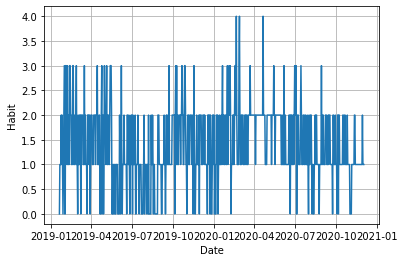

In [13]:
fig, ax = plt.subplots()
ax.plot(HabitsData.loc[:,"CalendarDate"], HabitsData.iloc[:,1])

ax.set(xlabel='Date', ylabel='Habit', title='')
ax.grid()

plt.show()

We started our analysis with the most simple and straightforward plot possible, plotting the entries of a single habit in a unique plot. We did this as a starting point to find out all the possible ways in which we can improve it, and then tackling one at a time. We map our TODO list: 

- the dates in the x-axis are not clear \[we can make them vertical or oblique\];
- the data is very difficult to interpret. We need some more meaningful information, like the **rolling average**;

### Rolling average
By creating a rolling average we aim to achieve a smoother plot, representing the sum of the habit's values in the previous month. Thus, each observation represents a moving average for the month (30 days before). 

In [14]:
# creation of the rolling average
for i in HabitNames:
    colName = "Rolling" + i
    HabitsData[colName] = HabitsData.loc[:,i].rolling(window=30).mean()
HabitsData.head()

,CalendarDate,☕,📕,📖,😴,Rolling☕,Rolling📕,Rolling📖,Rolling😴
0,2019-01-01,NaN,0,0,1,NaN,NaN,NaN,NaN
1,2019-01-02,NaN,1,0,1,NaN,NaN,NaN,NaN
2,2019-01-03,NaN,1,0,1,NaN,NaN,NaN,NaN
3,2019-01-04,NaN,0,0,1,NaN,NaN,NaN,NaN
4,2019-01-05,NaN,0,0,1,NaN,NaN,NaN,NaN


The resulting database view may make you think about an error, but in fact the rolling average is not defined for the first `n` days defined in the `rolling(window = n)` function. 

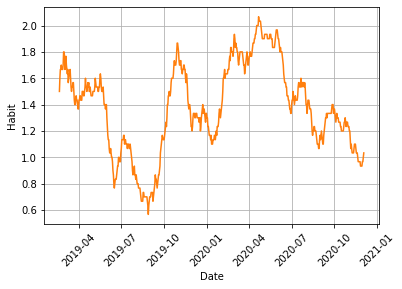

In [15]:
fig, ax = plt.subplots()
ax.plot(HabitsData.loc[:,"CalendarDate"], HabitsData.iloc[:,5], '#ff7f0e')

ax.set(xlabel='Date', ylabel='Habit', title='')
ax.grid()
plt.xticks(rotation=45)

plt.show()

Now the data is much more easy to read. We can see the months in which the habit has been performed more on average, and the months in which, on average, is has been performed less. 
Already this plot conveys much more meaning, compared to the previous one. To better compare them we can plot them on the same graph:

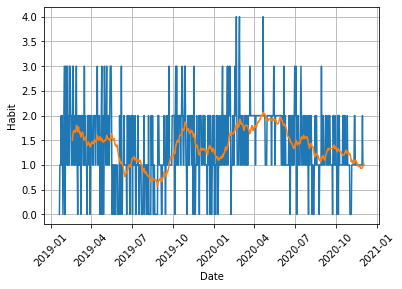

In [16]:
fig, ax = plt.subplots()
ax.set(xlabel='Date', ylabel='Habit', title='')
ax.grid()
plt.xticks(rotation=45)

ax.plot(HabitsData.loc[:,"CalendarDate"], HabitsData.iloc[:,1])
ax.plot(HabitsData.loc[:,"CalendarDate"], HabitsData.iloc[:,5])

plt.show()

Now we repeat the process of creation of the plots for each different habit: 

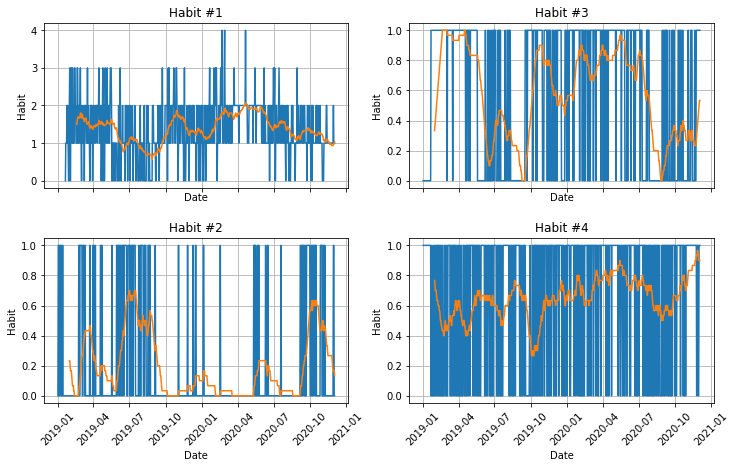

In [17]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize= [12,7], gridspec_kw={'hspace': 0.3})

for i in range(len(HabitNames)):
    n = max(i%2 + 1, 1) - 1
    m = int(min(round(i/2,0)+1, 2)) - 1
    
    axes[n,m].set(xlabel='Date', ylabel='Habit', title="Habit #"+str(i+1))
    axes[n,m].grid()
    axes[n,m].plot(HabitsData.loc[:,"CalendarDate"], HabitsData.iloc[:,i+1])
    axes[n,m].plot(HabitsData.loc[:,"CalendarDate"], HabitsData.iloc[:,i+1+numberOfHabits])
    axes[n,m].tick_params(axis="x", rotation=45) 

plt.show()

Now that we have explored, prepared, and modified our database, we may want to gain some more insights on the data. 

We may want to explore the question: 
> _Is there any correlation between different habits?_

In other words, can the data prove that some habit has a positive, or negative, effect on some other habit? Note that we need to be careful from this point on, not to mistake correlation with causation. In order to be able to prove that, some other considerations may be needed.

### Correlation among different habits

In [18]:
corrMatrix = HabitsData.iloc[:,numberOfHabits+1:2*numberOfHabits+1].corr(method='pearson', min_periods=1).round(3)
corrMatrix

,Rolling☕,Rolling📕,Rolling📖,Rolling😴
Rolling☕,1.000,-0.543,0.797,0.074
Rolling📕,-0.543,1.000,-0.415,0.028
Rolling📖,0.797,-0.415,1.000,-0.067
Rolling😴,0.074,0.028,-0.067,1.000


c:\python391\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 128213 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\python391\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 128214 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\python391\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 128213 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\python391\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 128214 missing from current font.
  font.set_text(s, 0, flags=flags)


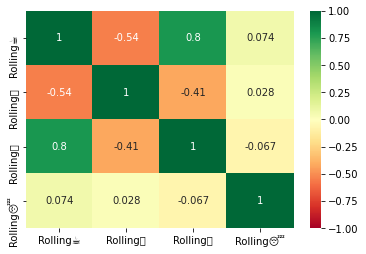

In [19]:
import seaborn as sns

sns.heatmap(corrMatrix, annot=True, vmin=-1.0, vmax=1.0, cmap="RdYlGn")
plt.show()

This representation is fine, it conveys the information we wanted. However, it could be made better by only showcasing the information that we need, i.e. only the lower, meaningful, triangle. We make this by making use of a matrix, then transforming into boolean values and using it as a mask, [see reference](https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e) for more details.

In [20]:
import numpy as np
np.triu(np.ones_like(corrMatrix))

array([[1., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 0., 1., 1.],
       [0., 0., 0., 1.]])

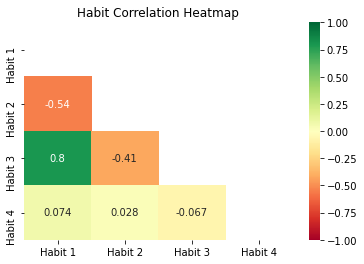

In [21]:
mask = np.triu(np.ones_like(corrMatrix, dtype=np.bool))
heatmap = sns.heatmap(corrMatrix, mask=mask, vmin=-1, vmax=1, annot=True, cmap='RdYlGn')
heatmap.set_title('Habit Correlation Heatmap');
labels = [f"Habit {i+1}" for i in range(numberOfHabits)]
heatmap.set_xticklabels(labels)
heatmap.set_yticklabels(labels)
plt.show()

While working on the plot we also changed the labels of the ticks knowing the following nomenclature:

In [22]:
for idx, habit in enumerate(corrMatrix.columns):
    print(f"Habit {idx+1}: {habit}")

Habit 1: Rolling☕
Habit 2: Rolling📕
Habit 3: Rolling📖
Habit 4: Rolling😴
